In [1]:
import sys
import glob
from pathlib import Path

config_path = Path('../../Sign-Language-Translator-(DL)')
sys.path.append(str(config_path))

In [2]:
from Src import get_random_samples_file_info, print_file_info

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchmetrics import Accuracy
from torchvision.transforms import v2, functional
from sklearn.metrics import classification_report
from torchvision import models
import torch.nn.functional as F

# model setting
from torch.optim import Adam
from torch import nn

# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
import argparse
import time

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
BASE_PATH = '..\\'

ASSETS_PATH = os.path.join(BASE_PATH, 'Assets')
DATASET_PATH = os.path.join(ASSETS_PATH, 'Datasets', 'SIBI dataset')

FILE_TRAINING_PATH = os.path.join(DATASET_PATH, 'Train', '*', '*')
LABEL_TRAINING_PATH = os.path.join(DATASET_PATH, 'Train', '*')

FILE_TEST_PATH = os.path.join(DATASET_PATH, 'Test', '*')

TRAIN_SPLIT = 0.9
VAL_SPLIT = 1 - TRAIN_SPLIT

BATCH_SIZE = 32

In [5]:
list_samples_files_path = glob.glob(FILE_TRAINING_PATH)
list_samples_labels_paths = glob.glob(LABEL_TRAINING_PATH)

list_test_files_path = glob.glob(FILE_TEST_PATH)

In [6]:
class_lists = [os.path.basename(path) for path in list_samples_labels_paths]

In [7]:
print(class_lists)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [8]:
random_samples_file_info = get_random_samples_file_info(list_samples_files_path)
print_file_info(random_samples_file_info, is_test=False)

======================== PATH INFO =========================
File Path: ..\Assets\Datasets\SIBI dataset\Train\A\image_A_(1723068164.7465832).jpg

===================== SPLIT FILE PATH ======================
Split File Path: ['..', 'Assets', 'Datasets', 'SIBI dataset', 'Train', 'A', 'image_A_(1723068164.7465832).jpg']

======================= INDEXED PATH =======================
Index -> 0: ..
Index -> 1: Assets
Index -> 2: Datasets
Index -> 3: SIBI dataset
Index -> 4: Train
Index -> 5: A
Index -> 6: image_A_(1723068164.7465832).jpg

================ DATASET TYPE INDEX: Train =================
Index of "Train": 4

======================= INDEX LABEL ========================
Label Index: 5

========================== LABEL ===========================
Label: A

======================== FILE NAME =========================
File Name: image_A_(1723068164.7465832).jpg

====================== FILE EXTENSION ======================
File Extension: .jpg

======================== FILE SIZE =======

In [9]:
random_test_file_info = get_random_samples_file_info(list_test_files_path)
print_file_info(random_test_file_info)

======================== PATH INFO =========================
File Path: ..\Assets\Datasets\SIBI dataset\Test\image_test_(1723085034.8100834).jpg

===================== SPLIT FILE PATH ======================
Split File Path: ['..', 'Assets', 'Datasets', 'SIBI dataset', 'Test', 'image_test_(1723085034.8100834).jpg']

======================= INDEXED PATH =======================
Index -> 0: ..
Index -> 1: Assets
Index -> 2: Datasets
Index -> 3: SIBI dataset
Index -> 4: Test
Index -> 5: image_test_(1723085034.8100834).jpg

============= DATASET TYPE INDEX: SIBI dataset =============
Index of "SIBI dataset": 3

======================= INDEX LABEL ========================
Label Index: 4

========================== LABEL ===========================
Label: Test

======================== FILE NAME =========================
File Name: image_test_(1723085034.8100834).jpg

====================== FILE EXTENSION ======================
File Extension: .jpg

======================== FILE SIZE =========

In [10]:
class ImagePathSamplesDataset(Dataset):
    def __init__(self, file_paths, image_cvt_to_gray=False):
        self.file_paths = file_paths
        self.image_cvt_to_gray = image_cvt_to_gray
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        file_path_split = file_path.split(os.path.sep)
        label = np.array(file_path_split[-2])
        
        image = cv2.imread(file_path)

        if self.image_cvt_to_gray:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image = np.expand_dims(image, -1)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        return image, label

In [11]:
class ImagePathTestDataset(Dataset):
    def __init__(self, file_paths, image_cvt_to_gray=False):
        self.file_paths = file_paths
        self.image_cvt_to_gray = image_cvt_to_gray
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)

        if self.image_cvt_to_gray:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image = np.expand_dims(image, -1)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        return image

In [45]:
torch_samples_dataset = ImagePathSamplesDataset(list_samples_files_path, image_cvt_to_gray=False)

torch_test_dataset = ImagePathTestDataset(list_test_files_path, image_cvt_to_gray=False)

Check Train Data
    shape-image: (224, 224, 3)
    dtype-image: uint8
    max-intensity: 255
    min-intensity: 0

    label: F
    label-shape: ()
    image-type: <U1


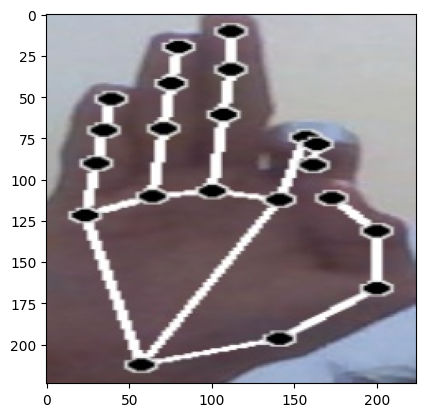

In [46]:
image, label = torch_samples_dataset[1000]
print(f"{'Check Train Data'.center(10, '=')}", end='')
print(f'''
    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {image.max()}
    min-intensity: {image.min()}

    label: {label}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
)

plt.imshow(image, cmap='gray')
plt.show()

Check Train Data
    shape-image: (224, 224, 3)
    dtype-image: uint8
    max-intensity: 255
    min-intensity: 0


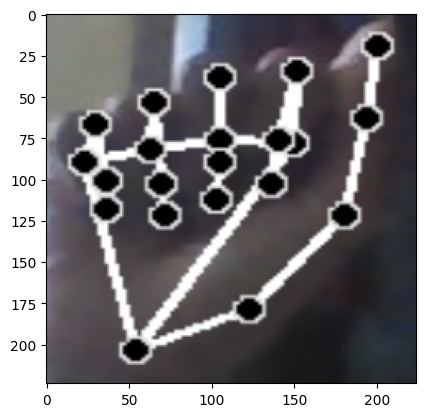

In [47]:
image = torch_test_dataset[0]
print(f"{'Check Train Data'.center(10, '=')}", end='')
print(f'''
    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {image.max()}
    min-intensity: {image.min()}'''
)

plt.imshow(image, cmap='gray')
plt.show()

In [15]:
len(torch_samples_dataset)

5200

In [49]:
n_train_samples = int(round(len(torch_samples_dataset) * TRAIN_SPLIT))
n_valid_samples = int(round(len(torch_samples_dataset) * VAL_SPLIT))

torch_train_data, torch_valid_data = torch.utils.data.random_split(
    dataset=torch_samples_dataset,
    lengths=[n_train_samples, n_valid_samples],
	generator=torch.Generator().manual_seed(42)
)

In [50]:
len(torch_train_data), len(torch_valid_data)

(4680, 520)

Check Train Data
    shape-image: (224, 224, 3)
    dtype-image: uint8
    max-intensity: 255
    min-intensity: 0

    label: F
    label-shape: ()
    image-type: <U1


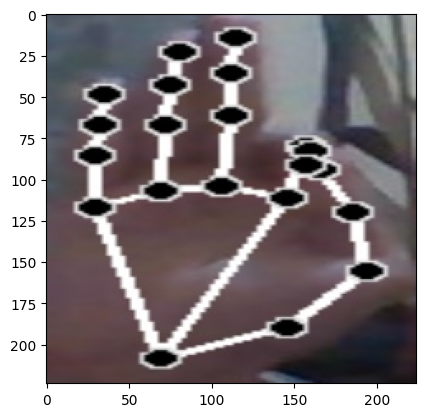

In [51]:
image, label = torch_train_data[1000]
print(f"{'Check Train Data'.center(10, '=')}", end='')
print(f'''
    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {image.max()}
    min-intensity: {image.min()}

    label: {label}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
)

plt.imshow(image, cmap='gray')
plt.show()

In [52]:
class TransformSamples(Dataset):
    def __init__(self, torch_dataset, transform_image, transform_label):
        self.torch_dataset = torch_dataset
        self.transform_image = transform_image
        self.transform_label = transform_label
    
    def __len__(self):
        return len(self.torch_dataset)

    def __getitem__(self, idx):
        image, label = self.torch_dataset[idx]
        image = self.transform_image(image)
        label = self.transform_label(label)
        return image, label

In [53]:
class LabelToInteger(object):
    def __init__(self, class_lists):
        self.class_lists = class_lists

    def __call__(self, label):
        label_to_index_func = self.__label_to_index()
        label_str = str(label)
        label = torch.tensor(label_to_index_func[label_str.upper()])
        # label = F.one_hot(label, num_classes=len(self.class_lists))
        return label
    
    def __label_to_index(self):
        label_to_index = {value:index for index, value in enumerate(self.class_lists)}
        return label_to_index

In [114]:
train_image_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_image_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

sample_label_transform = v2.Compose([
    LabelToInteger(class_lists),
    v2.ToDtype(torch.long)
])

In [115]:
torch_train_data_transformed = TransformSamples(
    torch_train_data, 
    train_image_transform, 
    sample_label_transform
)

torch_valid_data_transformed = TransformSamples(
    torch_valid_data, 
    valid_image_transform, 
    sample_label_transform
)

Check Train Data
    image-shape: torch.Size([3, 224, 224])
    image-dtype: torch.float32
    max-intensity: 1.0
    min-intensity: 0.0

    label: 5 -> F
    label-shape: torch.Size([])
    label-dtype: torch.int64


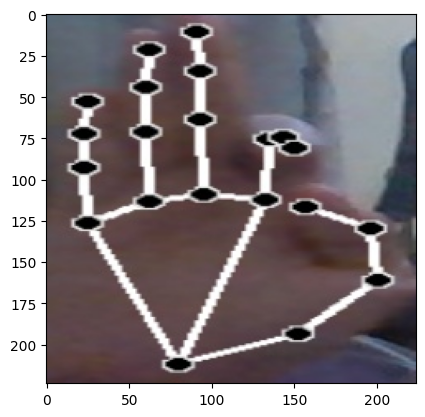

In [116]:
random_index = np.random.randint(len(torch_train_data_transformed))
image, label = torch_train_data_transformed[random_index]
image_plot = np.array(functional.to_pil_image(image))

print(f"{'Check Train Data'.center(10, '=')}", end='')
print(f'''
    image-shape: {image.shape}
    image-dtype: {image.dtype}
    max-intensity: {image.max()}
    min-intensity: {image.min()}

    label: {label} -> {class_lists[int(label)]}
    label-shape: {label.shape}
    label-dtype: {label.dtype}'''
)

plt.imshow(image_plot, cmap='gray')
plt.show()

In [117]:
# initialize the train, validation, and test data loaders
train_data_loader = DataLoader(torch_train_data_transformed, shuffle=True, batch_size=BATCH_SIZE)
val_data_loader = DataLoader(torch_valid_data_transformed, batch_size=BATCH_SIZE)

In [118]:
len(train_data_loader), len(val_data_loader)

(147, 17)

In [119]:
from torchsummary import summary

class GestureRecognitionModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(GestureRecognitionModel, self).__init__()
        base_model = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

        # Remove the fully connected layers of VGG16
        # self.vgg16_features = nn.Sequential(*list(base_model.features))
        self.vgg16_features = base_model.features

        # Freeze the base model layers
        for param in self.vgg16_features.parameters():
            param.requires_grad = False
        
        # Add custom layers on top
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.fc1 = nn.Linear(base_model.classifier[0].in_features, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 128) 
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, num_classes) 
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass input through the base model
        x = self.vgg16_features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Fully connected layers with dropout
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        # x = self.softmax(x) 

        # Softmax Location: Typically, the Softmax layer is not included in the model's forward pass unless explicitly required (e.g., when exporting the model for inference). In PyTorch, loss functions like CrossEntropyLoss include the LogSoftmax operation internally, so it's often better to omit Softmax from the model and apply it only during inference if needed.

        return x

model = GestureRecognitionModel(num_classes=len(class_lists))

In [120]:
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [121]:
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=adam_optimizer, 
    step_size=15, 
    gamma=0.5
)

In [122]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        # Set to training mode
        model.train()
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
        print()
    
    return model

In [124]:
# Usage
trained_model = train_model(
    model=model, 
    train_loader=train_data_loader, 
    val_loader=val_data_loader, 
    criterion=criterion, 
    optimizer=adam_optimizer, 
    scheduler=exp_lr_scheduler,
    num_epochs=2  # Adjust as needed
)
